In [1]:
import os
import numpy as np
import tqdm
import torch
import matplotlib.pyplot as plt

from quadrotor_diffusion.utils.nn.training import Trainer
from quadrotor_diffusion.models.diffusion_wrapper import LatentDiffusionWrapper
from quadrotor_diffusion.models.vae_wrapper import VAE_Wrapper
from quadrotor_diffusion.utils.dataset.normalizer import Normalizer
from quadrotor_diffusion.utils.nn.args import TrainerArgs
from quadrotor_diffusion.utils.logging import iprint as print
from quadrotor_diffusion.utils.plotting import plot_states,  plot_ref_obs_states, add_gates_to_course, add_trajectory_to_course, course_base_plot
from quadrotor_diffusion.utils.simulator import play_trajectory, create_perspective_rendering
from quadrotor_diffusion.utils.file import get_checkpoint_file, get_sample_folder, load_course_trajectory
from quadrotor_diffusion.utils.nn.post_process import fit_to_recon

In [2]:
COURSE = "../data/courses/triangle/13"
EXPERIMENT = 165

model: LatentDiffusionWrapper = None
ema: LatentDiffusionWrapper = None
normalizer: Normalizer = None
trainer_args: TrainerArgs = None

chkpt = get_checkpoint_file("../logs/training", EXPERIMENT)
diff, ema, normalizer, trainer_args = Trainer.load(chkpt)
model = ema.cuda()
print(f"Loaded {chkpt}")
print(f"Using {normalizer}")

vae_experiment: int = 157
chkpt = get_checkpoint_file("../logs/training", vae_experiment)
vae_wrapper: VAE_Wrapper = None
vae_wrapper, _, _, _ = Trainer.load(chkpt, get_ema=False)
vae_wrapper = vae_wrapper.cuda()
vae_downsample = 2 ** (len(vae_wrapper.args[1].channel_mults) - 1)

model.encoder = vae_wrapper.encode
model.decoder = vae_wrapper.decode

[ 2739554633 ] Loaded ../logs/training/165.LatentDiffusionWrapper.Mar.20_12:38_AM/checkpoints/epoch_399_loss_0.0319
[ 2739554633 ] Using NoNormalizer


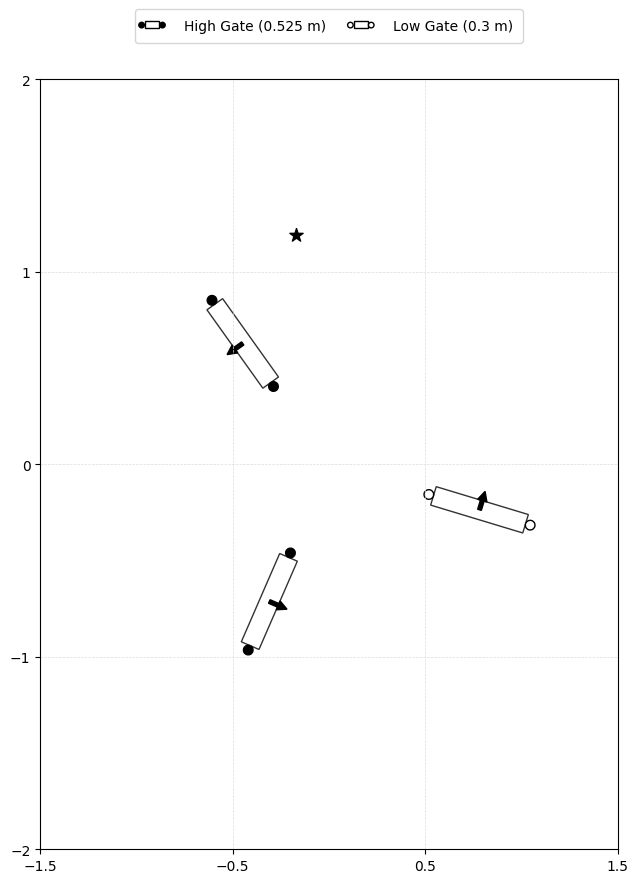

In [3]:
course = np.load(os.path.join(COURSE, "course.npy"))

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)

In [4]:
local_conditioning = torch.tensor(np.tile(course[0], (6,1)), dtype=torch.float32).cuda()
local_conditioning = local_conditioning.unsqueeze(0).expand((10, -1, -1))

global_conditioning = np.vstack((course[1:], course[1:0]))
null_tokens = np.tile(np.array(5 * np.ones((1, 4))), (6 - len(global_conditioning), 1))
global_conditioning = np.vstack((global_conditioning, null_tokens))
global_conditioning = torch.tensor(global_conditioning, dtype=torch.float32).cuda()

trajectories = model.sample(10, 128, vae_downsample, "cuda", local_conditioning=local_conditioning, conditioning=global_conditioning)

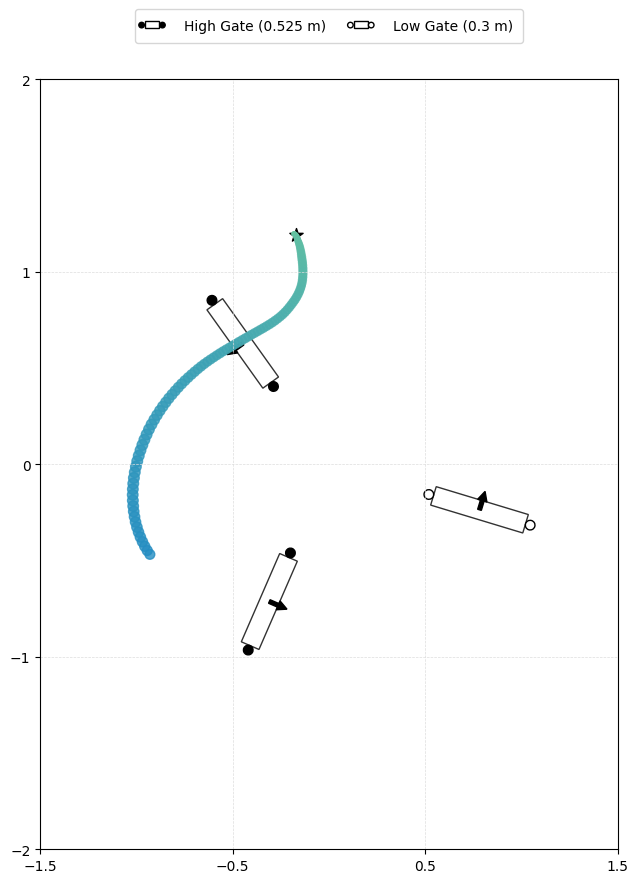

In [15]:
SEGMENT_0 = 1

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(trajectories[SEGMENT_0].cpu().numpy())

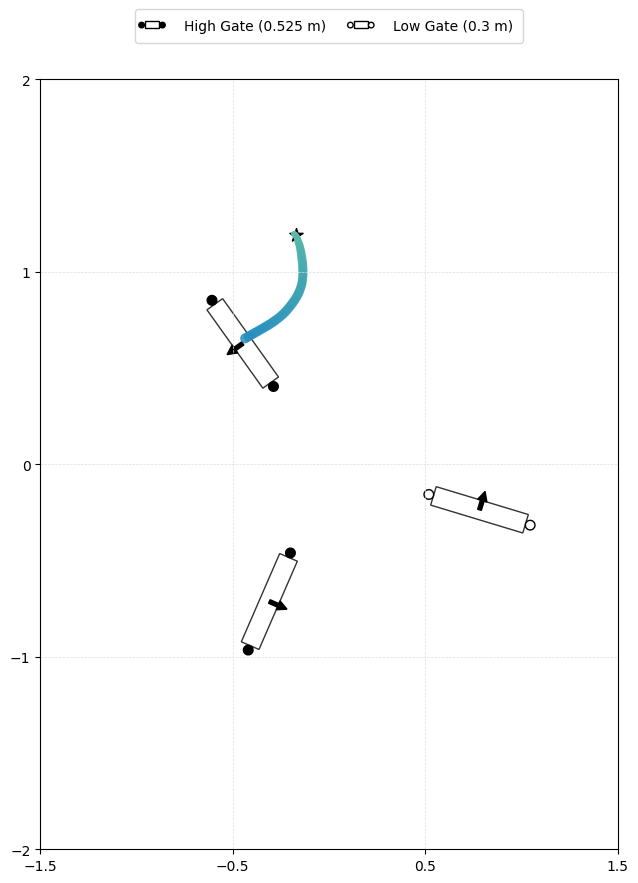

In [16]:
segment_0 = trajectories[SEGMENT_0].cpu().numpy()
ending_idx = np.argmin(np.linalg.norm(segment_0 - course[1][:3], axis=1))
segment_0 = segment_0[:ending_idx]

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(segment_0)

In [17]:
local_conditioning = np.hstack((segment_0[-6:], np.zeros((6, 1))))
local_conditioning = torch.tensor(local_conditioning, dtype=torch.float32).cuda()
local_conditioning = local_conditioning.unsqueeze(0).expand((10, -1, -1))

global_conditioning = np.vstack((course[2:], course[1:1]))
null_tokens = np.tile(np.array(5 * np.ones((1, 4))), (6 - len(global_conditioning), 1))
global_conditioning = np.vstack((global_conditioning, null_tokens))
global_conditioning = torch.tensor(global_conditioning, dtype=torch.float32).cuda()


trajectories = model.sample(10, 128, vae_downsample, "cuda", local_conditioning=local_conditioning, conditioning=global_conditioning).cpu().numpy()

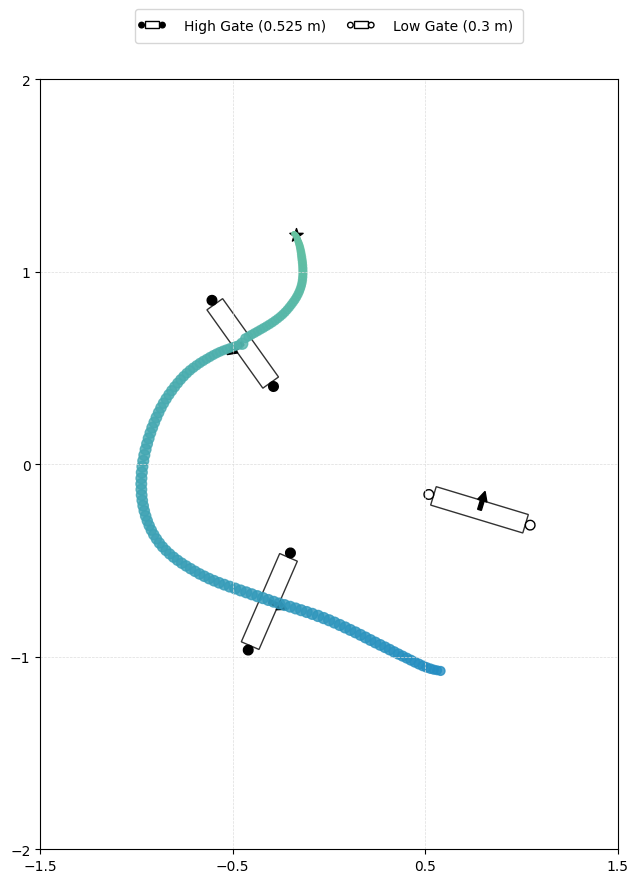

In [24]:
segment_0_tiled = np.tile(segment_0, (10, 1, 1))
trajectories_concated = np.concatenate((segment_0_tiled, trajectories), axis=1)

SEGMENT_1 = 0

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(trajectories_concated[SEGMENT_1])

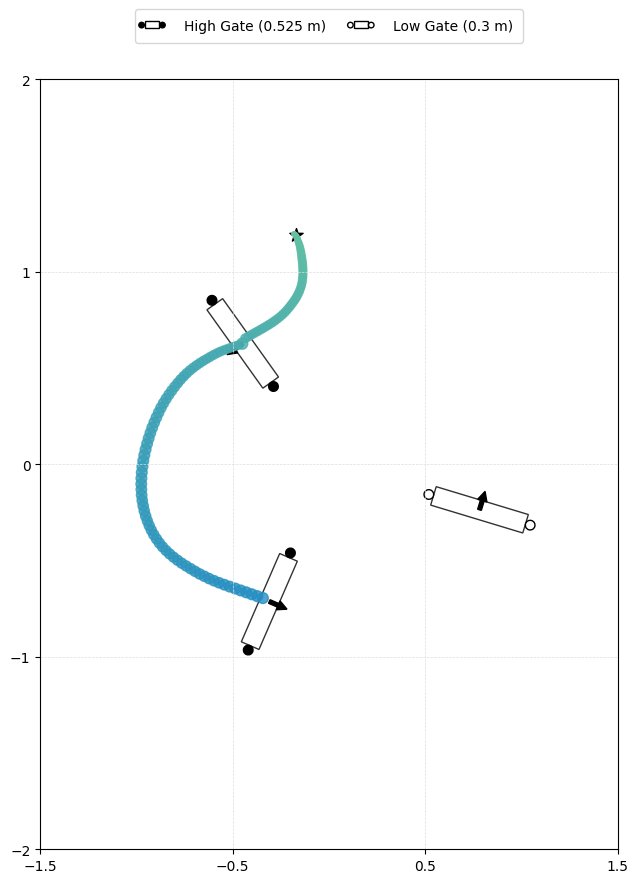

In [25]:
segment_1 = trajectories_concated[SEGMENT_1]
segment_1_no_concat = trajectories[SEGMENT_1]
ending_idx = np.argmin(np.linalg.norm(segment_1 - course[2][:3], axis=1))
segment_1 = segment_1[:ending_idx]

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(segment_1)

In [26]:
local_conditioning = np.hstack((segment_1[-6:], np.zeros((6, 1))))
local_conditioning = torch.tensor(local_conditioning, dtype=torch.float32).cuda()
local_conditioning = local_conditioning.unsqueeze(0).expand((10, -1, -1))

global_conditioning = np.vstack((course[3:], course[1:2]))
null_tokens = np.tile(np.array(5 * np.ones((1, 4))), (6 - len(global_conditioning), 1))
global_conditioning = np.vstack((global_conditioning, null_tokens))
global_conditioning = torch.tensor(global_conditioning, dtype=torch.float32).cuda()


trajectories = model.sample(10, 128, vae_downsample, "cuda", local_conditioning=local_conditioning, conditioning=global_conditioning).cpu().numpy()

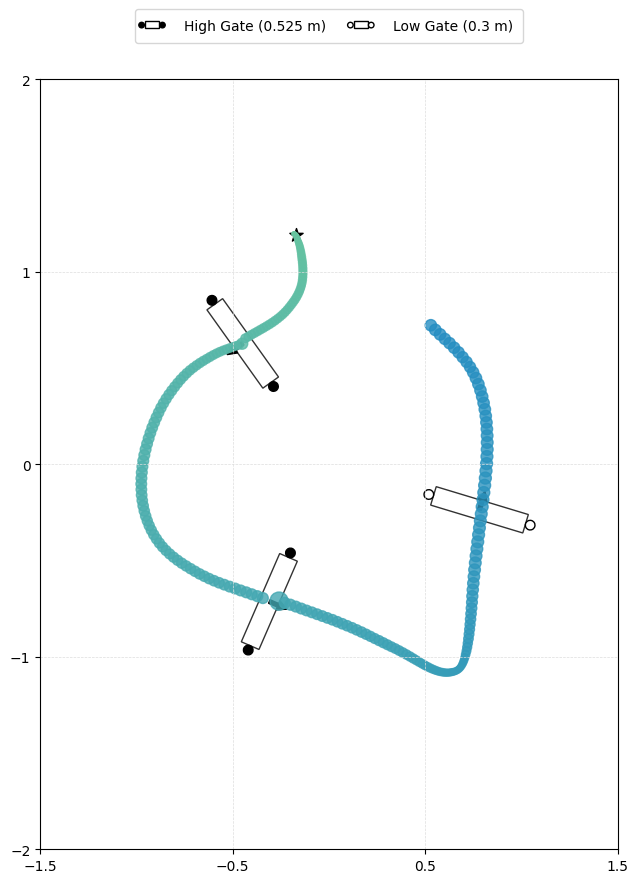

In [32]:
segment_1_tiled = np.tile(segment_1, (10, 1, 1))
trajectories_concated = np.concatenate((segment_1_tiled, trajectories), axis=1)

SEGMENT_2 = 5

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(trajectories_concated[SEGMENT_2])

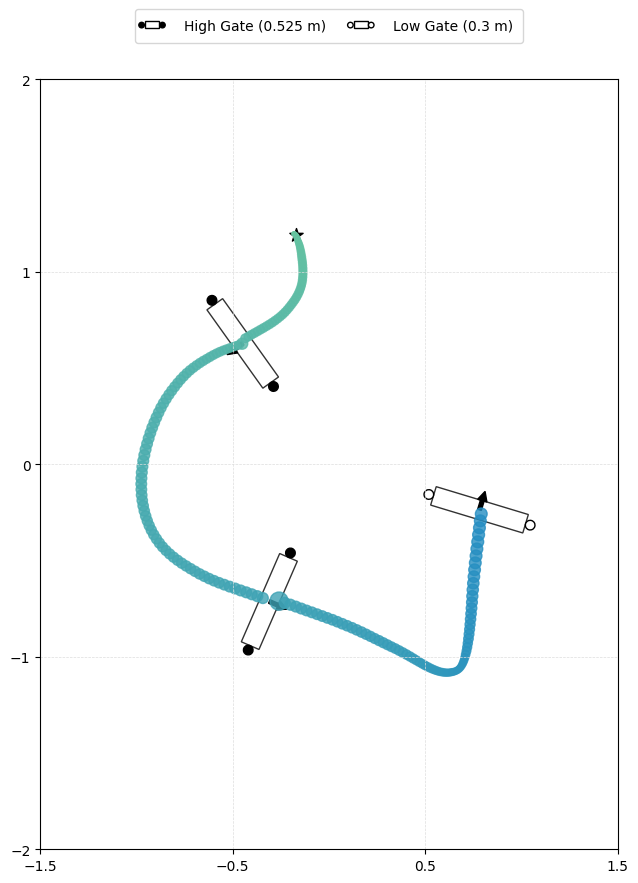

In [33]:
segment_2 = trajectories_concated[SEGMENT_2]
ending_idx = np.argmin(np.linalg.norm(segment_2 - course[3][:3], axis=1))
segment_2 = segment_2[:ending_idx]

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(segment_2)

In [34]:
local_conditioning = np.hstack((segment_2[-6:], np.zeros((6, 1))))
local_conditioning = torch.tensor(local_conditioning, dtype=torch.float32).cuda()
local_conditioning = local_conditioning.unsqueeze(0).expand((10, -1, -1))

global_conditioning = np.vstack((course[4:], course[1:3]))
null_tokens = np.tile(np.array(5 * np.ones((1, 4))), (6 - len(global_conditioning), 1))
global_conditioning = np.vstack((global_conditioning, null_tokens))
global_conditioning = torch.tensor(global_conditioning, dtype=torch.float32).cuda()


trajectories = model.sample(10, 128, vae_downsample, "cuda", local_conditioning=local_conditioning, conditioning=global_conditioning).cpu().numpy()

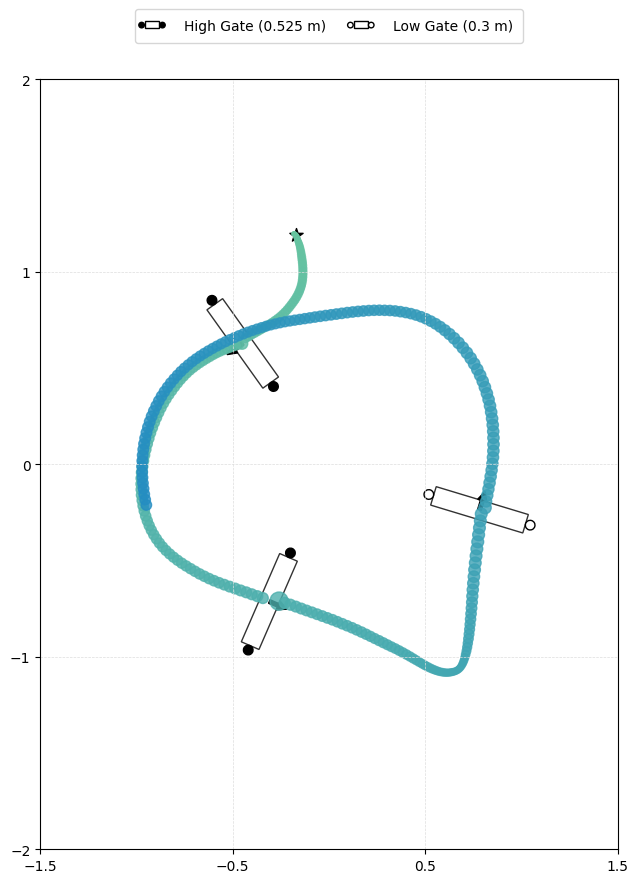

In [35]:
segment_2_tiled = np.tile(segment_2, (10, 1, 1))
trajectories_concated = np.concatenate((segment_2_tiled, trajectories), axis=1)

SEGMENT_3 = 0

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(trajectories_concated[SEGMENT_3])

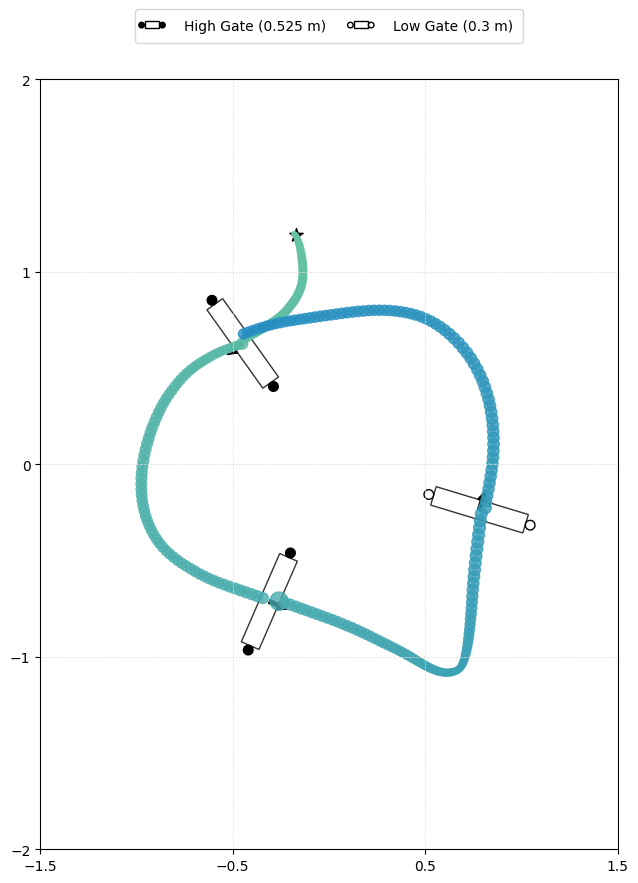

In [36]:
segment_3 = trajectories[SEGMENT_3]
ending_idx = np.argmin(np.linalg.norm(segment_3 - course[1][:3], axis=1))
segment_3 = np.vstack((segment_2, segment_3[:ending_idx]))

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(segment_3)

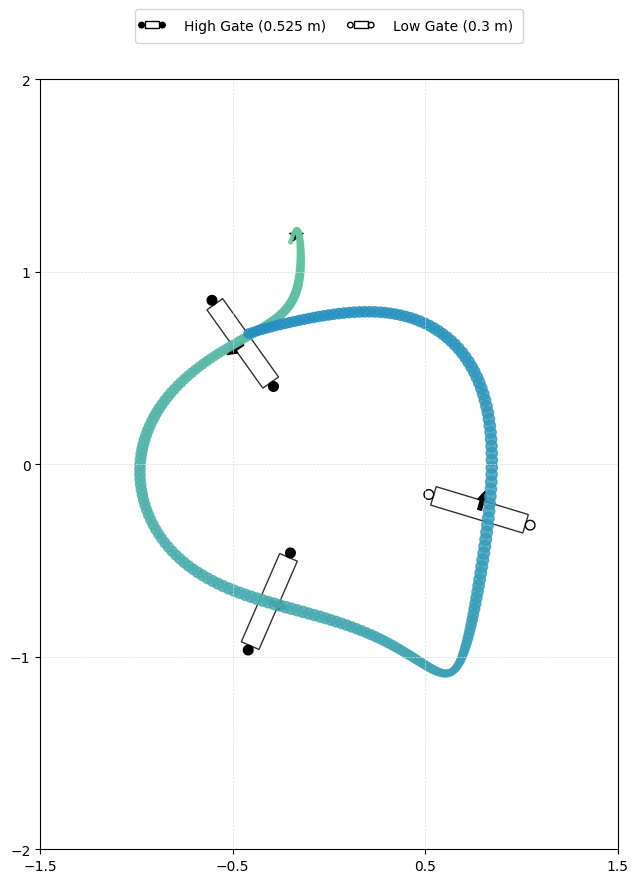

In [37]:
fitted = fit_to_recon(np.vstack((segment_3, segment_1_no_concat)), 30)
fitted = [fitted[i][:-112] for i in range(3)]

_, ax = course_base_plot()
add_gates_to_course(course, ax, has_end=False)
add_trajectory_to_course(fitted[0], velocity_profile=fitted[1])

In [38]:
overlapping_idx = np.argmin(np.linalg.norm(fitted[0][:len(fitted[0])//2] - course[1][:3], axis=1))
print("velocity error", fitted[1][overlapping_idx] - fitted[1][-1])
print("acc error", fitted[2][overlapping_idx] - fitted[2][-1])

[ 3622005267 ] velocity error [0.0803667  0.09250464 0.03056416]
[ 3622005267 ] acc error [-0.49724821  0.04834891  0.07159329]
